In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import dlc_practical_prologue as prologue

In [2]:
### ONLY FOR THE ANALYSES OF THE RESULTS
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print_shapes_Net = False
mini_batch_size = 100
print_errors = False

In [4]:
def reshape_targets(train_target, test_target):
    new_train_target = torch.empty(1000,2)
    new_test_target = torch.empty(1000,2)
    for i in range(1000):
        if train_target[i] == 1 :
            new_train_target[i,0] = 0
            new_train_target[i,1] = 1

        else:
            new_train_target[i,0] = 1
            new_train_target[i,1] = 0

        if test_target[i] == 1:
            new_test_target[i,0] = 0
            new_test_target[i,1] = 1

        else:
            new_test_target[i,0] = 1
            new_test_target[i,1] = 0
    return new_train_target, new_test_target

In [5]:
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)) #6x6
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)) #conv : 4x4, maxpool : 2x2
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [6]:
class Net_bn(nn.Module):
    def __init__(self, nb_hidden):
        super(Net_bn, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), kernel_size=2, stride=2)) #6x6
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), kernel_size=2, stride=2)) #conv : 4x4, maxpool : 2x2
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        #x = nn.Softmax(dim=1)(x)
        return x

In [7]:
class Net2(nn.Module):
    def __init__(self, nb_hidden):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=2)
        self.fc1 = nn.Linear(128, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        if print_shapes_Net:
            print("initial shape", x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=1))
        if print_shapes_Net:
            print("1 conv",x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        if print_shapes_Net:
            print("2 conv", x.shape)
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size=2))
        if print_shapes_Net:
            print("3 conv", x.shape)
        x = F.relu(self.conv4(x))
        if print_shapes_Net:
            print("4 conv",x.shape)
        x = F.relu(self.fc1(x.view(-1, 128)))
        if print_shapes_Net:
            print("fc1",x.shape)
        x = self.fc2(x)
        if print_shapes_Net:
            print("final",x.shape)
        return x

######################################################################

In [8]:
class Net3(nn.Module):
    def __init__(self, nb_hidden):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=2)
        self.fc1 = nn.Linear(128, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)

    def forward(self, x):
        if print_shapes_Net:
            print("initial shape", x.shape)
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), kernel_size=1))
        if print_shapes_Net:
            print("1 conv",x.shape)
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), kernel_size=2))
        if print_shapes_Net:
            print("2 conv", x.shape)
        x = F.relu(F.max_pool2d(self.bn3(self.conv3(x)), kernel_size=2))
        if print_shapes_Net:
            print("3 conv", x.shape)
        x = F.relu(self.bn4(self.conv4(x)))
        if print_shapes_Net:
            print("4 conv",x.shape)
        x = F.relu(self.fc1(x.view(-1, 128)))
        if print_shapes_Net:
            print("fc1",x.shape)
        x = self.fc2(x)
        if print_shapes_Net:
            print("final",x.shape)
        return x

######################################################################

In [10]:
def train_model(model, train_input, train_target, mini_batch_size):
    criterion = nn.MSELoss()
    eta = 5e-1
    mini_batch_size=100
    
    for e in range(25):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            
            output = model(train_input.narrow(0, b, mini_batch_size))            
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            #print(loss)
            model.zero_grad()
            loss.backward()
            sum_loss = sum_loss + loss.item()
            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad

In [11]:
def train_model2(model, train_input, train_target, mini_batch_size, lr):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)

    mini_batch_size=100
    
    for e in range(25):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            
            output = model(train_input.narrow(0, b, mini_batch_size))            
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            #print(loss)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss.item()

In [12]:
def compute_nb_errors(model, input, target, mini_batch_size): 
    #target[1000], predicted_classes[100], output[100*2]
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [13]:
###ANALYSE THE RESULTS
def analyse_results(train_errors, test_errors, title):
    input_size = 1000
    print('Average train error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(train_errors)) / train_input.size(0),
                                                          np.mean(train_errors), input_size))
    print("Train error standard deviation : {:0.2f}".format(np.std(train_errors)))

    print('Average test error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(test_errors)) / test_input.size(0),
                                                          np.mean(test_errors), input_size))
    print("Test error standard deviation : {:0.2f}".format(np.std(test_errors)))


    train_err = [x*100 / input_size for x in train_errors]
    test_err = [x*100 / input_size for x in test_errors]

    plt.figure
    plt.title(title)
    plt.boxplot([train_err, test_err], labels=['train error', 'test error'])
    plt.ylabel("Error percentage")
    plt.show()

iteration 0/10
iteration 1/10
iteration 2/10
iteration 3/10
iteration 4/10
iteration 5/10
iteration 6/10
iteration 7/10
iteration 8/10
iteration 9/10
Average train error 7.74% 77.40/1000
Train error standard deviation : 53.86
Average test error 22.83% 228.30/1000
Test error standard deviation : 33.50


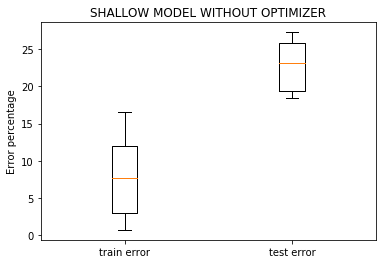

In [15]:
#shallow model without optimizer
nb = 10
train_errors = []
test_errors = []

for k in range(nb):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    
    model = Net(64)
    print("iteration {:d}/{:d}".format(k+1,nb))
    train_model(model, train_input, new_train_target, mini_batch_size)
    nb_train_error = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
    nb_test_error = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
    
    if print_errors:
        print('train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_error) / test_input.size(0),
                                                      nb_train_error, test_input.size(0)))

        print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_error) / test_input.size(0),
                                                          nb_test_error, test_input.size(0)))
    
    train_errors.append(nb_train_error)
    test_errors.append(nb_test_error)

analyse_results(train_errors, test_errors, "SHALLOW MODEL WITHOUT OPTIMIZER")

iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
Average train error 3.51% 35.10/1000
Train error standard deviation : 16.22
Average test error 18.06% 180.60/1000
Test error standard deviation : 18.62


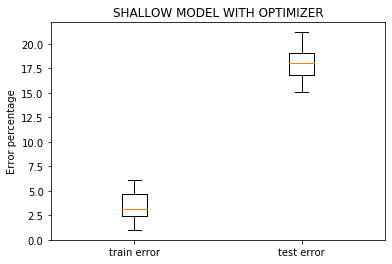

In [16]:
####shallow model with optimizer
lr = 0.001
train_errors = []
test_errors = []

for i in range(nb):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    
    model = Net(64)
    print("iteration {:d}/{:d}".format(i+1,nb))
    train_model2(model, train_input, new_train_target, mini_batch_size, lr)
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
    
    if print_errors:
        print('train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / test_input.size(0),
                                                  nb_train_errors, test_input.size(0)))
        print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))
    train_errors.append(nb_train_errors)
    test_errors.append(nb_test_errors)
    
analyse_results(train_errors, test_errors, "SHALLOW MODEL WITH OPTIMIZER")

iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
Average train error 0.75% 7.50/1000
Train error standard deviation : 11.81
Average test error 19.77% 197.70/1000
Test error standard deviation : 19.21


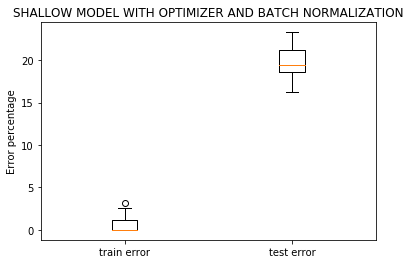

In [17]:
#with batch normalization and optimizer
lr = 0.001
train_errors = []
test_errors = []

for i in range(nb):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    
    model = Net_bn(64)
    train_model2(model, train_input, new_train_target, mini_batch_size, lr)
    
    print("iteration {:d}/{:d}".format(i+1,nb))
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
    
    if print_errors:
        print('train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / test_input.size(0),
                                                  nb_train_errors, test_input.size(0)))
        print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                          nb_test_errors, test_input.size(0)))
    train_errors.append(nb_train_errors)
    test_errors.append(nb_test_errors)
    
analyse_results(train_errors, test_errors, "SHALLOW MODEL WITH OPTIMIZER AND BATCH NORMALIZATION")

## Deeper model

iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
iteration 9/10
Average train error 12.81% 128.10/1000
Train error standard deviation : 56.39
Average test error 20.68% 206.80/1000
Test error standard deviation : 19.71


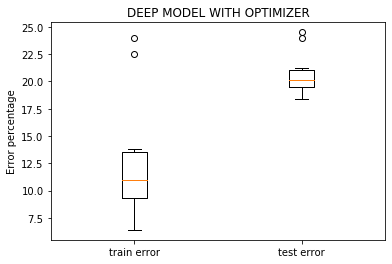

In [18]:
###########
# DEEP MODEL WITH OPTIMIZER
lr = 0.001
train_errors = []
test_errors = []

for i in range(nb):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    
    model = Net2(64)
    train_model2(model, train_input, new_train_target, mini_batch_size, lr)
    
    print("iteration {:d}/{:d}".format(i+1,nb))
    
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
    
    if print_errors:
        print('train error Net2 {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                           nb_train_errors, train_input.size(0)))
        print('test error Net2 {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                           nb_test_errors, test_input.size(0)))
    train_errors.append(nb_train_errors)
    test_errors.append(nb_test_errors)    
    
analyse_results(train_errors, test_errors, "DEEP MODEL WITH OPTIMIZER")

In [ ]:
#########################################################################################
#########################################END#############################################
#########################################################################################

In [ ]:
######################################################################
# Deeper model

model = Net2(64)

lr = 0.001
train_model2(model, train_input, new_train_target, mini_batch_size, lr)

nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
print('train error Net2 {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                   nb_train_errors, train_input.size(0)))

nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
print('test error Net2 {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                   nb_test_errors, test_input.size(0)))

#### Test for lr choice

In [ ]:
#lr = 0.001 seems good: train error: 12%, test error: 20%
for lr in [0.001,0.005, 0.01, 0.05, 0.1, 0.5]:
    model = Net2(64)
    train_model2(model, train_input, new_train_target, mini_batch_size, lr)

    nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
    print('train error Net2 {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                       nb_train_errors, train_input.size(0)))

    nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
    print('test error Net2 {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                       nb_test_errors, test_input.size(0)))
    

### With batch normalization

In [ ]:
######################################################################
# Deeper model

model = Net3(64)
lr = 0.05
train_model2(model, train_input, new_train_target, mini_batch_size, lr)

nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
print('train error Net3 {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                   nb_train_errors, train_input.size(0)))

nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
print('test error Net3 {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                   nb_test_errors, test_input.size(0)))

In [ ]:
#lr = 0.05??? : train error: 0.9%, test error: 20%
for lr in [0.001,0.005, 0.01, 0.05, 0.1, 0.5]:
    model = Net3(64)
    train_model2(model, train_input, new_train_target, mini_batch_size, lr)

    nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
    print("learning rate: ", lr)
    print('train error Net3 {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                       nb_train_errors, train_input.size(0)))

    nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
    print('test error Net3 {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                       nb_test_errors, test_input.size(0)))
    

In [ ]:
lr = 0.05
for i in range(5):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    
    model = Net3(64)
    train_model2(model, train_input, new_train_target, mini_batch_size, lr)

    nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
    print('train error Net3 {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                       nb_train_errors, train_input.size(0)))

    nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
    print('test error Net3 {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                       nb_test_errors, test_input.size(0)))

In [ ]:
###ANALYSES OF THE RESULTS
print('Average train error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(nb_train_errors)) / train_input.size(0),
                                                      np.mean(nb_train_errors), train_input.size(0)))
print("Train error standard deviation : {:0.2f}".format(np.std(nb_train_errors)))

print('Average test error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(nb_test_errors)) / test_input.size(0),
                                                      np.mean(nb_test_errors), test_input.size(0)))
print("Test error standard deviation : {:0.2f}".format(np.std(nb_test_errors)))


train_err = [x*100 / train_input.size(0) for x in nb_train_errors]
test_err = [x*100 / test_input.size(0) for x in nb_test_errors]

plt.figure
plt.title("Train and test errors")
plt.boxplot([train_err, test_err], labels=['train error', 'test error'])
plt.ylabel("Error percentage")
plt.show()

In [ ]:
####let's find the best learning rate (shallow with optimizer)
for lr in [0.001,0.005, 0.01, 0.05, 0.1, 0.5]:
    model = Net(64)
    train_model2(model, train_input, new_train_target, mini_batch_size, lr)
    print("learning rate=", lr)
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
    print('train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / test_input.size(0),
                                              nb_train_errors, test_input.size(0)))
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
    print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))
    

In [ ]:
#with batch normalization and optimizer
for lr in [0.001,0.005, 0.01, 0.05, 0.1, 0.5]:
    model = Net_bn(64)

    train_model2(model, train_input, new_train_target, mini_batch_size, lr)
    print("Learning rate :", lr )
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target, mini_batch_size)
    print('train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / test_input.size(0),
                                              nb_train_errors, test_input.size(0)))
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target, mini_batch_size)
    print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))
    ##good lr : 0.001